<a href="https://colab.research.google.com/github/raza-abidii/raza_projects_labs/blob/main/Module_2_Lab_1_Manifold_Learning_Methods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Module 2: Appreciating, Interpreting and Visualizing Data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn import datasets

In [2]:
n_points = 1000
X, color = datasets.make_s_curve(n_points, random_state=0)

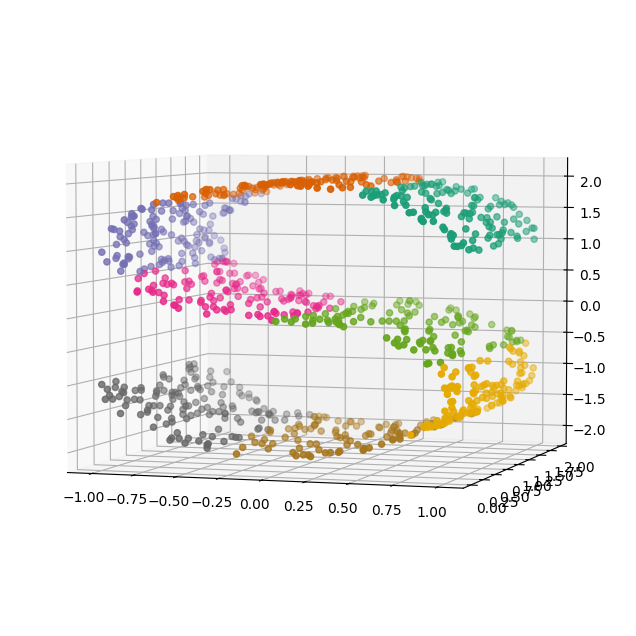

In [3]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=color, cmap=plt.cm.Dark2)
ax.view_init(4, -72)

### Step 1a: First lets compute the distance matrix (pairwise Euclidean distances) from the data

In [4]:
def dist(a, b):
  return np.sqrt(sum((a - b) ** 2))

distances = np.array([[dist(p1, p2) for p2 in X] for p1 in X])
print(distances.shape)

(1000, 1000)


### Step 1b: Let us keep only k nearest neighbors for each point in the distance matrix.

In [6]:
n_neighbors = 10
neighbors = np.zeros(distances.shape)

sort_distances = np.argsort(distances, axis=1)[:, 1:n_neighbors+1]
for k,i in enumerate(sort_distances):
    neighbors[k,i] = distances[k,i]
neighbors.shape

(1000, 1000)

### Step 2: Weight graph edges by inter-point distances and then apply Dijkstra’s all-pairs shortest-paths algorithm.

In [7]:
from scipy.sparse.csgraph import shortest_path

graph = shortest_path(neighbors, directed=False)

### Step 3: Take the top d eigenvectors of the Gram matrix.

In [8]:
gram = (graph ** 2)

n_samples = gram.shape[0]

meanrows = np.sum(gram, axis=0) / n_samples
meancols = (np.sum(gram, axis=1)/n_samples)[:, np.newaxis]

meanall = meanrows.sum() / n_samples

gram -= meanrows
gram -= meancols
gram += meanall

In [9]:
eig_val_cov, eig_vec_cov = np.linalg.eig(gram)

eig_pairs = [(np.abs(eig_val_cov[i]), eig_vec_cov[:, i]) for i in range(len(eig_val_cov))]

eig_pairs.sort(key=lambda x: x[0], reverse=True)
eig_pa_chebyshevirs = np.array(eig_pairs, dtype=object)

n_components = 2

reduced_matrix = np.zeros((n_components, gram.shape[1]))
for i in range(n_components):
  reduced_matrix[i,:] = eig_pa_chebyshevirs[i,1]
reduced_matrix = reduced_matrix.T

## Plotting the resultant reduced_matrix

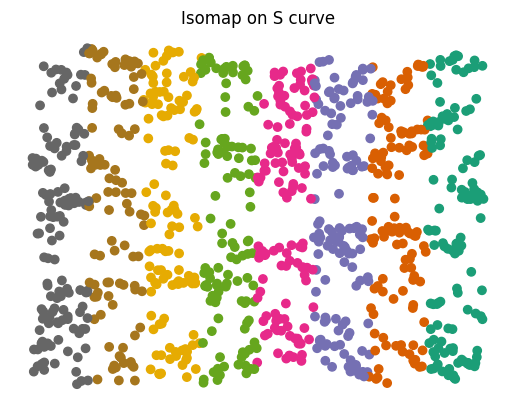

In [10]:
ax = fig.add_subplot(111)
plt.scatter(reduced_matrix[:, 0], reduced_matrix[:, 1], c=color, cmap=plt.cm.Dark2)
plt.title("Isomap on S curve")
plt.axis('off')
plt.show()

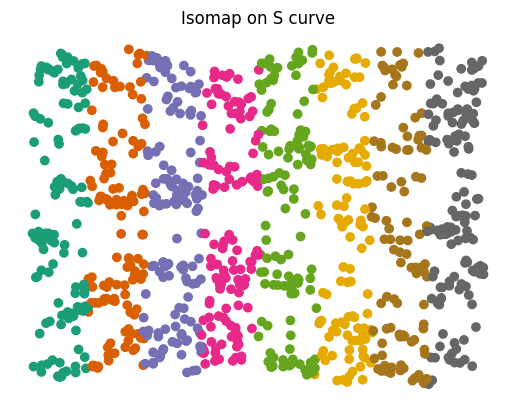

In [11]:
from sklearn.manifold import Isomap

Y = Isomap(n_neighbors=10, n_components=2).fit_transform(X)

ax = fig.add_subplot(111)
plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Dark2)
plt.title("Isomap on S curve")
plt.axis('off')
plt.show()

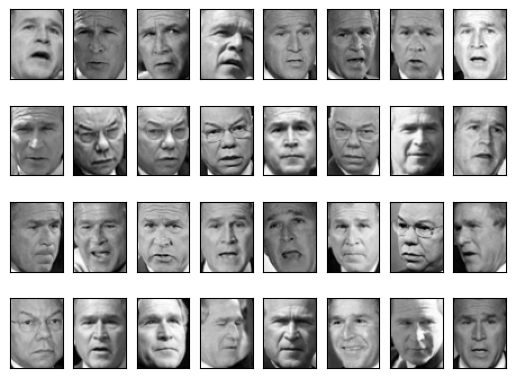

In [12]:
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=200)
faces.data.shape

fig, ax = plt.subplots(4, 8, subplot_kw=dict(xticks=[], yticks=[]))
for i, axi in enumerate(ax.flat):
    axi.imshow(faces.images[i], cmap='gray')

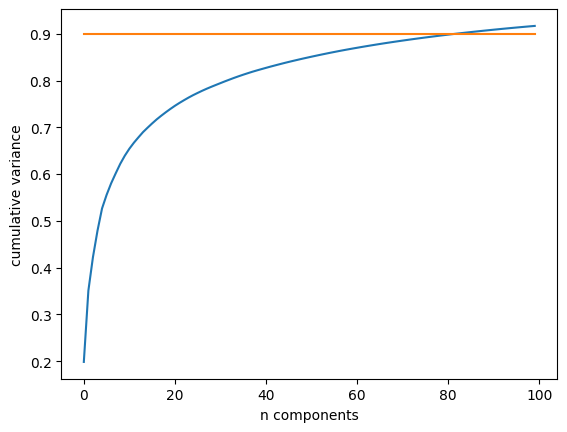

In [13]:
from sklearn.decomposition import PCA as RandomizedPCA
model = RandomizedPCA(100).fit(faces.data)
plt.plot(np.cumsum(model.explained_variance_ratio_))
plt.xlabel('n components')
plt.ylabel('cumulative variance')
plt.plot(range(100), 0.9*np.ones(100))

In [14]:
model = Isomap(n_components=2, n_neighbors = 5)
proj = model.fit_transform(faces.data)
proj.shape

(766, 2)

In [15]:
from matplotlib import offsetbox

def plot_components(data, model, images=None, ax=None, thumb_frac=0.05, cmap='gray'):

    ax = ax or plt.gca()
    proj = model.fit_transform(data)
    ax.plot(proj[:, 0], proj[:, 1], '.k')

    if images is not None:
        min_dist_2 = (thumb_frac * max(proj.max(0) - proj.min(0))) ** 2
        shown_images = np.array([2 * proj.max(0)])
        for i in range(data.shape[0]):
            dist = np.sum((proj[i] - shown_images) ** 2, 1)
            if np.min(dist) < min_dist_2:
                continue
            shown_images = np.vstack([shown_images, proj[i]])
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(images[i], cmap=cmap),
                                      proj[i])
            ax.add_artist(imagebox)

Text(0, 0.5, 'Image Darkness')

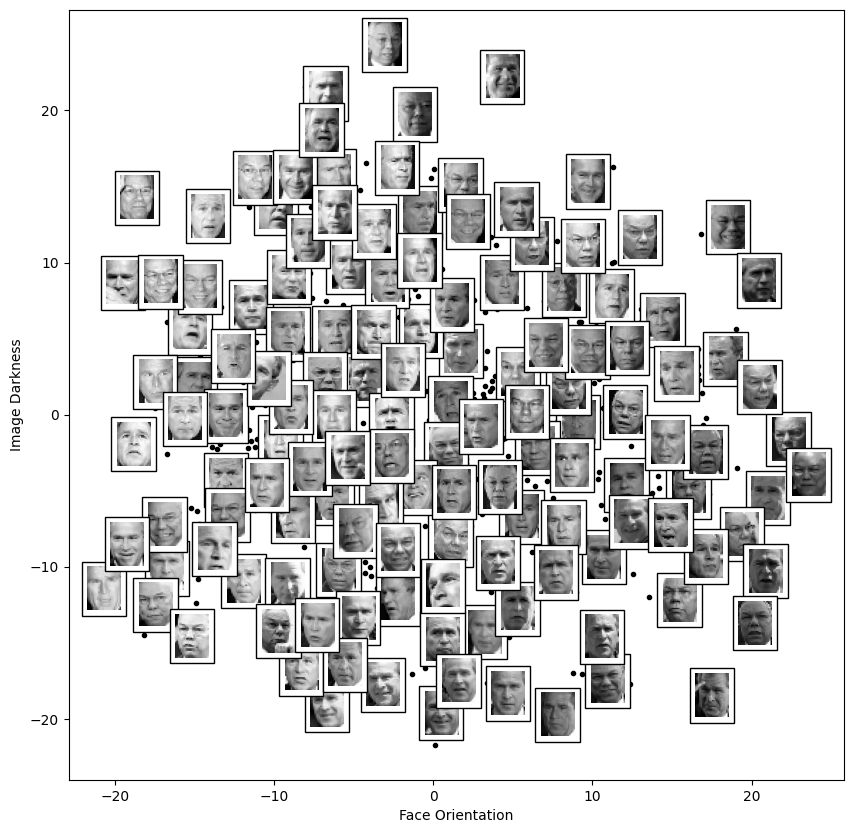

In [16]:
fig, ax = plt.subplots(figsize=(10, 10))
plot_components(faces.data,
                model=Isomap(n_components=2, n_neighbors = 5),
                images=faces.images[:, ::2, ::2])
plt.xlabel("Face Orientation")
plt.ylabel("Image Darkness")

## exercise 1

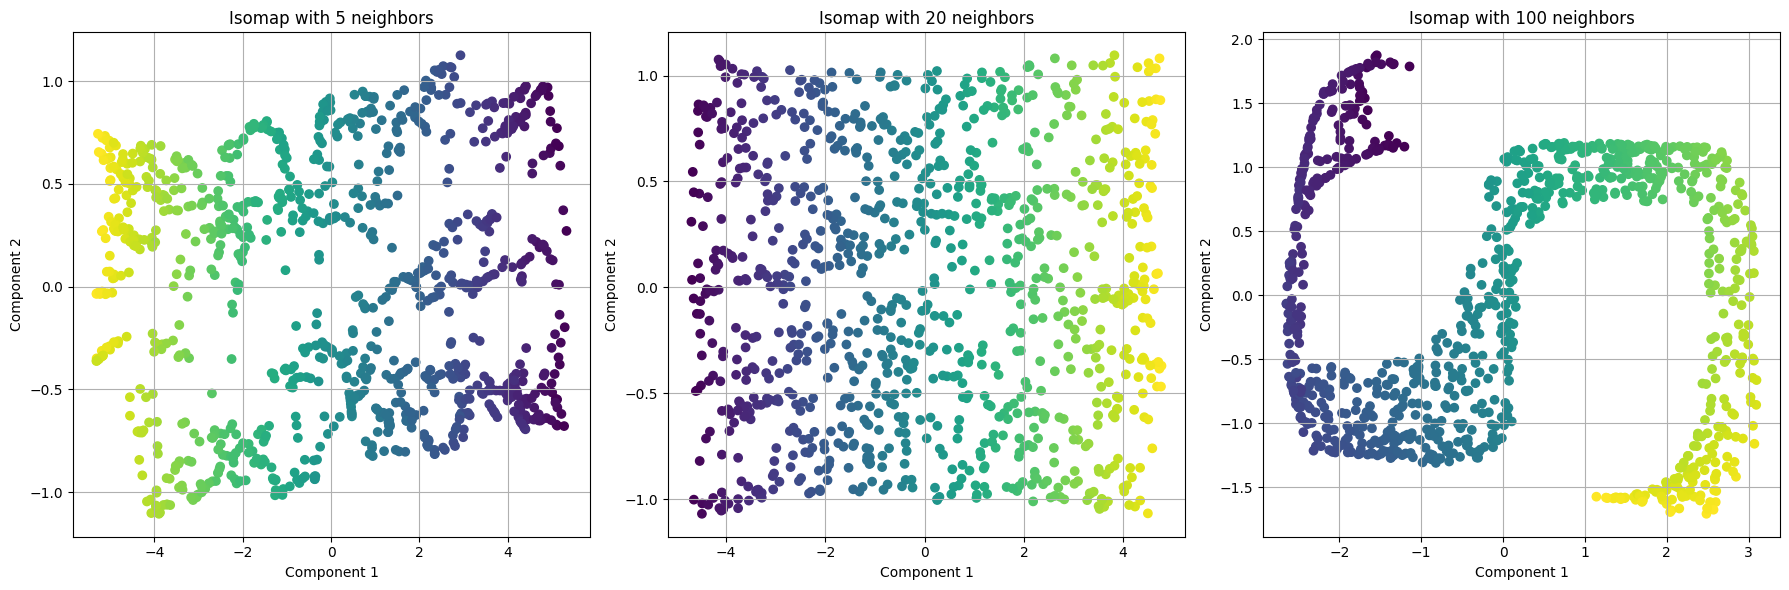

In [21]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

n_neighbors_values = [5, 20, 100]

for i, n_neighbors in enumerate(n_neighbors_values):
    model = Isomap(n_neighbors=n_neighbors, n_components=2)
    Y = model.fit_transform(X)

    axes[i].scatter(Y[:, 0], Y[:, 1], c=color, cmap='viridis')
    axes[i].set_title(f"Isomap with {n_neighbors} neighbors")
    axes[i].set_xlabel('Component 1')
    axes[i].set_ylabel('Component 2')
    axes[i].grid(True)

plt.tight_layout()
plt.show()

## exercise 2

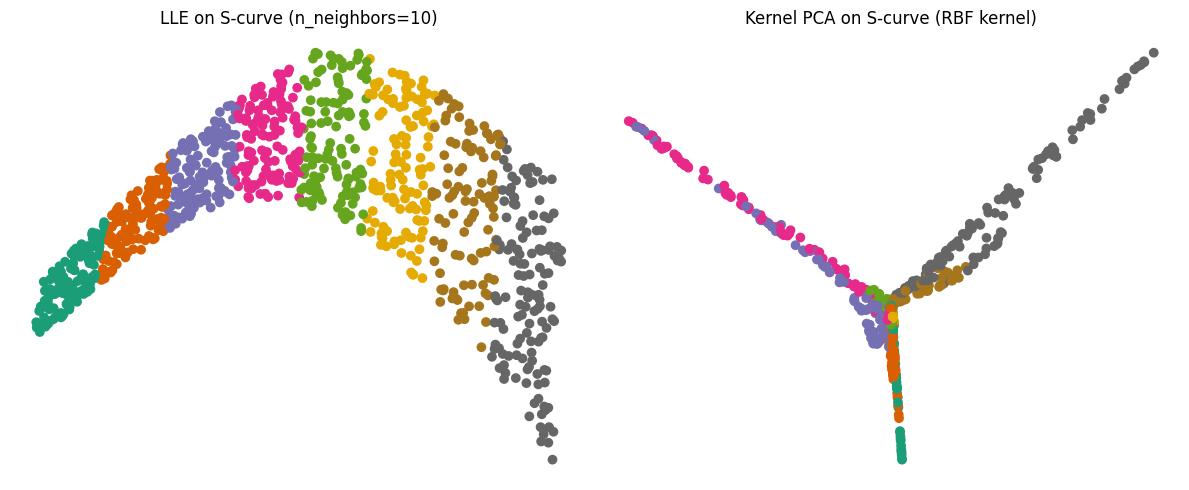

In [18]:
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.decomposition import KernelPCA

lle = LocallyLinearEmbedding(n_components=2, n_neighbors=10)
X_lle = lle.fit_transform(X)

kpca = KernelPCA(n_components=2, kernel='rbf', gamma=15)
X_kpca = kpca.fit_transform(X)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].scatter(X_lle[:, 0], X_lle[:, 1], c=color, cmap=plt.cm.Dark2)
axes[0].set_title("LLE on S-curve (n_neighbors=10)")
axes[0].axis('off')

axes[1].scatter(X_kpca[:, 0], X_kpca[:, 1], c=color, cmap=plt.cm.Dark2)
axes[1].set_title("Kernel PCA on S-curve (RBF kernel)")
axes[1].axis('off')

plt.tight_layout()
plt.show()

## exercise 3

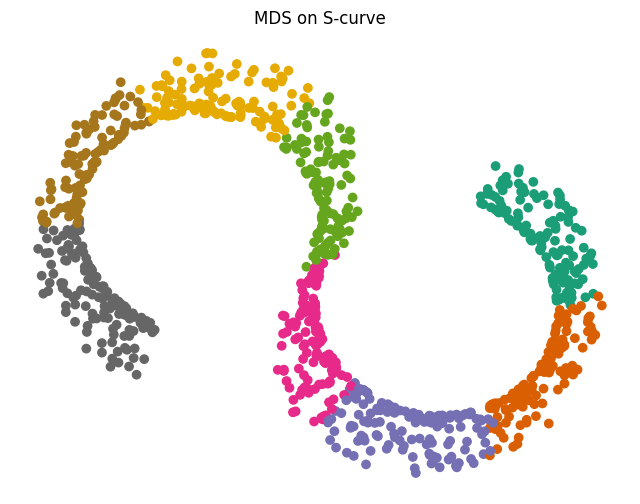

In [19]:
from sklearn.manifold import MDS

# Apply Multi-dimensional Scaling (MDS)
mds = MDS(n_components=2, random_state=0)
X_mds = mds.fit_transform(X)

# Create a figure and plot the result
plt.figure(figsize=(8, 6))
plt.scatter(X_mds[:, 0], X_mds[:, 1], c=color, cmap=plt.cm.Dark2)
plt.title("MDS on S-curve")
plt.axis('off')
plt.show()

## exercise 4

Original data shape: (1000, 3)
Data with missing values shape: (1000, 3)
Number of missing values: 146
Data after imputation shape: (1000, 3)
Number of missing values after imputation: 0


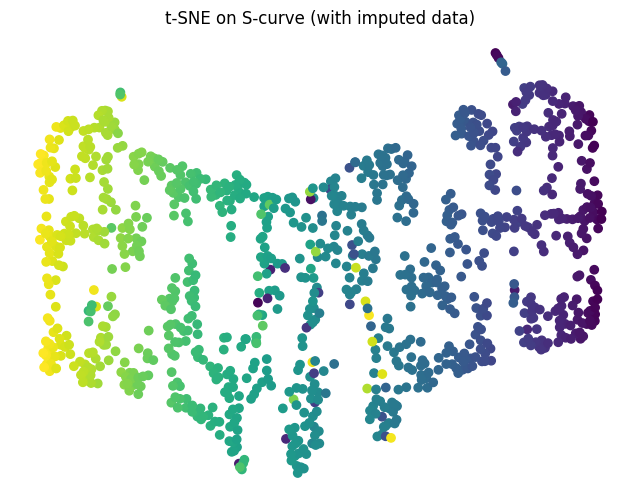

In [20]:
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

X_with_missing = X.copy()
np.random.seed(42)
n_samples, n_features = X_with_missing.shape
n_missing = int(0.05 * n_samples * n_features)
missing_rows = np.random.randint(0, n_samples, n_missing)
missing_cols = np.random.randint(0, n_features, n_missing)
X_with_missing[missing_rows, missing_cols] = np.nan

print("Original data shape:", X.shape)
print("Data with missing values shape:", X_with_missing.shape)
print("Number of missing values:", np.sum(np.isnan(X_with_missing)))

imputer = SimpleImputer(missing_values=np.nan, strategy='median')
X_imputed = imputer.fit_transform(X_with_missing)

print("Data after imputation shape:", X_imputed.shape)
print("Number of missing values after imputation:", np.sum(np.isnan(X_imputed)))

tsne_imputed = TSNE(n_components=2, random_state=0, perplexity=30)
Y_imputed = tsne_imputed.fit_transform(X_imputed)

plt.figure(figsize=(8, 6))
plt.scatter(Y_imputed[:, 0], Y_imputed[:, 1], c=color, cmap='viridis')
plt.title("t-SNE on S-curve (with imputed data)")
plt.axis('off')
plt.show()